In [1]:
import pandas as pd
import numpy as np
import config
import datetime
from sqlalchemy import text
import plotly
import plotly.express as px
import ipywidgets
from urllib.request import urlopen
import json
import plotly.graph_objects as go
import geopandas as gpd
import warnings
import pyproj
import plotly.io as pio
import pickle
print(config.version)
print(config.connection_string)
print(plotly.__version__, ipywidgets.__version__, pd.__version__, np.__version__)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=UserWarning) 

3.2.0.Dev
postgresql://postgres:sa@localhost/icip
6.3.1 8.1.7 2.0.0 1.26.4


In [58]:
# gdf = gpd.read_file("../CA/contours-iris.gpkg")
# gdf = gdf.to_crs(epsg=4326)
# gdf["fid"] = gdf.index
# gdf["lon"] = gdf.geometry.centroid.x
# gdf["lat"] = gdf.geometry.centroid.y
# gdf = gdf.sort_values(by="code_iris")
# with open("gdf.pickle", "wb") as f:
#     pickle.dump(gdf, f)
with open("gdf.pickle", "rb") as f:
     gdf_france = pickle.load(f)

In [303]:
spe_df = pd.read_sql("select id, label_long label from specialite", config.connection_string, index_col="id")
spe_df.T

id             1             2             3                   4    
label  Psychiatre  Anesthésiste  Dermatologue  Gastro-entérologue  \

id              5             6         7           8         9            10   
label  Gynécologue  Opthtalmogue  Pédiatre  Radiologue  Dentiste  Généraliste  \

id              11         12              13        14          15   
label  Cardiologue  Chirugien  Endocrinologue  Gériatre  Neurologue  \

id                           16           17                18            19   
label  Oto-rhino-laryngologiste  Pneumologue  Radiothérapeuthe  Rhumatologue  \

id               20  
label  Stomatologue

In [438]:
code_commune = "060%" #"75101" #"75056" #"69123" #"38185"  #"06088" "38205" "38548" "2A004" "382050000" ["385480000", "382050000"]
# Renommer code_commune en code_apl
# code de l'iris soit len=9 soit % in
specialite = 10
year = 21
source="PA" # PA or PS
time=30 # 30 or 45
time_type="HC" # HC or HP

if type(code_commune) is list:
    type_code = "LIST"
elif "%" in code_commune:
    type_code = "LIKE"
elif len(code_commune) == 5:
    type_code = "COM"
elif len(code_commune) == 2:
    type_code = "LIKE"
    code_commune = code_commune + "%"
elif len(code_commune) == 9:
    type_code = "IRIS"
else:
    type_code="ERROR"
print(f"Type code: {type_code}")

Type code: LIKE


In [439]:
sql = f"""
select i.*, c.nom commune_nom from iris.commune c
join iris.iris i on i.commune_id=c.id
where c.code='{code_commune}'
order by i.id
"""
commune_nom = None
if type_code=="COM":
    iris_df = pd.read_sql(sql, config.connection_string)
    iriss = iris_df["code"].values
    commune_nom = iris_df["commune_nom"].iloc[0] if len(iris_df) > 0 else None
elif type_code in ["IRIS", "LIKE"]:
    iriss = [code_commune]
elif type_code == "LIST":
    iriss = code_commune
print(f"Found {len(iriss)} iris for {commune_nom}")

Found 1 iris for None


In [440]:
if type_code == "LIKE":
    gdf = gdf_france[gdf_france["code_iris"].str.startswith(code_commune[:-1])]
elif len(iriss)>0:
    gdf = gdf_france[gdf_france["code_iris"].isin(iriss)]
else:
    gdf = gdf_france[gdf_france["code_insee"]==code_commune]
    type_code="INSEE"
if commune_nom is None:
    commune_nom=gdf["nom_commune"].iloc[0] if len(gdf) > 0 else None
    print(f"Found {len(gdf)} iris in {commune_nom}")
geojson=gdf.__geo_interface__
print(f"Found {len(gdf)} geo iris for {commune_nom}, type_code: {type_code}")
# gdf_france[gdf_france["nom_commune"].str.startswith("Lyon")].head(100)
gdf.head(2)

Found 392 iris in Aiglun
Found 392 geo iris for Aiglun, type_code: LIKE


cleabs code_insee nom_commune  iris  code_iris   
15710  IRIS____0000000060010000      06001      Aiglun  0000  060010000  \
16058  IRIS____0000000060020000      06002      Amirat  0000  060020000   

      nom_iris type_iris                                           geometry   
15710   Aiglun         Z  MULTIPOLYGON (((6.91239 43.83179, 6.91553 43.8...  \
16058   Amirat         Z  MULTIPOLYGON (((6.83233 43.91845, 6.83309 43.9...   

         fid       lon        lat  
15710  15710  6.934954  43.852733  
16058  16058  6.812954  43.896714

In [441]:
sql = f"""
select * from apl.apl_study s
where s.specialite_id={specialite}
and s.year={year}
and s.source='{source}'
and s.time={time}
and s.time_type='{time_type}'
order by date desc
limit 1
"""
study_df = pd.read_sql(sql, config.connection_string)
study_df

year  specialite_id source  time time_type   exp       mean       std   
0    21             10     PA    30        HC -0.12  66.239008  36.20015  \

         q10        q25        q50        q75         q90  min         max   
0  29.513588  40.432111  56.872725  85.083597  117.776403  0.0  681.212229  \

                        date           key  
0 2025-10-27 15:23:38.204846  923382762052

In [442]:
key = study_df["key"].iloc[0]
print(f"Study key: {key}")
if type_code == "COM":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and code_commune='{code_commune}'
    """
elif type_code == "IRIS":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string='{code_commune}'
    """
elif type_code == "LIKE":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string like '{code_commune}'
    """
elif type_code == "LIST":
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    and a.iris_string in {tuple(code_commune)}
    """
apl = pd.read_sql(text(sql), config.connection_string)
if type_code == "INSEE" or len(apl) == 0:
    sql=f"""
    select * from apl.apl a
    where a.study_key = {key}
    """
    apl = pd.read_sql(sql, config.connection_string)
len(apl)

Study key: 923382762052


392

In [443]:
apl["code_iris"]=apl["iris_string"]
gdf = gdf.merge(apl, on="code_iris", how="left", suffixes=('', '_dest')).copy()
len(gdf)

392

In [444]:
gdf["pretty"]=gdf["apl"].apply(lambda x: round(x, 0))
gdf["pretty"] = gdf["pretty"].astype(np.int32)
gdf["r_pretty"]=gdf["R"].apply(lambda x: round(x, 2))
gdf["popgp_pretty"]=gdf["pop_gp"].apply(lambda x: round(x, 0))
gdf["popgp_pretty"] = gdf["popgp_pretty"].astype(np.int32)


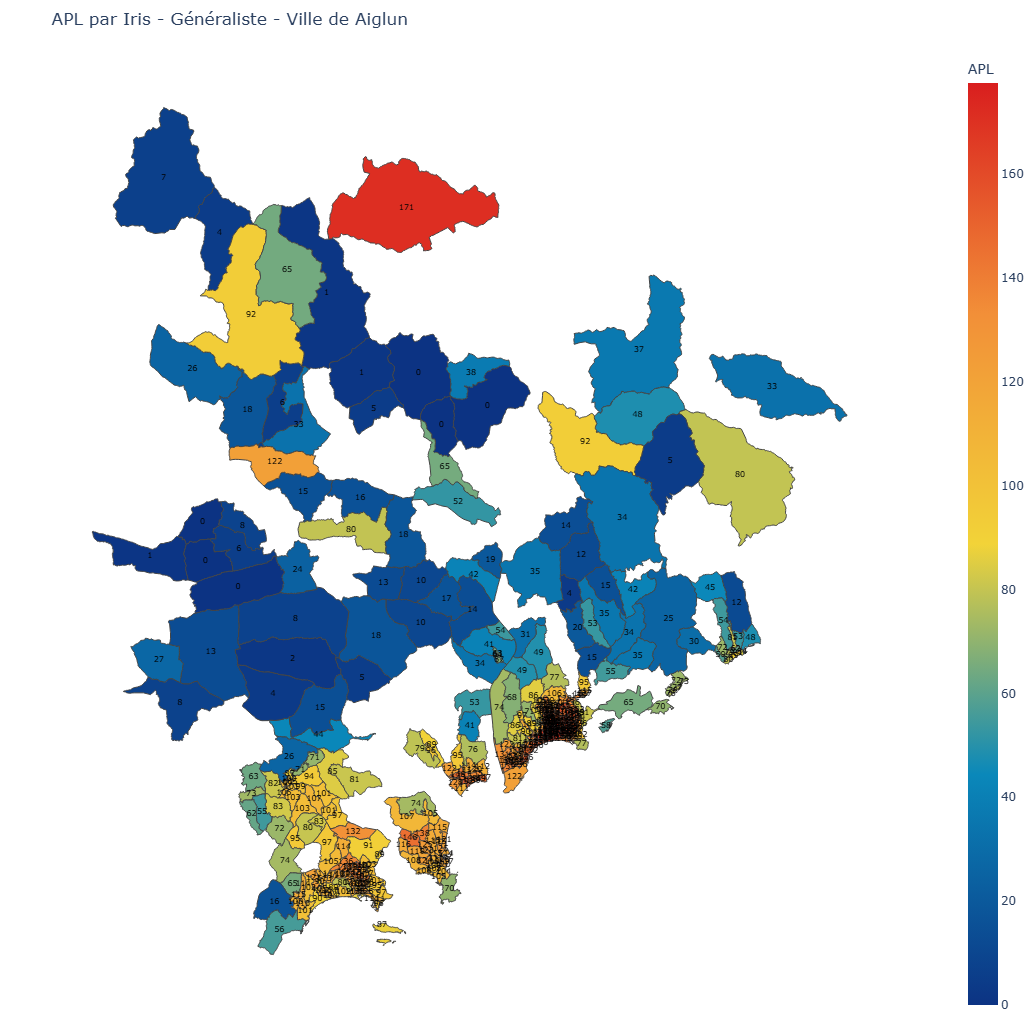

In [445]:
fig = go.Figure()

z_values=gdf["apl"]

fig.add_trace(go.Choropleth(
    geojson=geojson,
    locations=gdf["fid"],
    z=z_values,
    zmin=0,
    zmax=z_values.max(),
    text=gdf.apply(
        lambda row: f"Nom: {row['nom_iris']}<br>APL: {row['pretty']}<br>Nb: {row['nb']}<br>PopGP: {row['popgp_pretty']}<br>R: {row['r_pretty']}",
        axis=1
    ),
    hoverinfo="text",
    showscale=True,
    colorscale="Portland",
    colorbar={"title": "APL"}
))
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

fig.add_trace(go.Scattergeo(
    lon=gdf["lon"],
    lat=gdf["lat"],
    text=gdf["pretty"].astype(str),
    mode="text",
    textfont=dict(color="black", size=8),
    hoverinfo="skip",
    showlegend=False,
    marker=dict(
            color='#99ff99',
            size=8,
            line=dict(
                color='#006600',
                width=2
            )
        ),
))
fig.update_layout(
    geo=dict(
        projection_type="mercator",
        center={"lat": center_lat, "lon": center_lon},
        fitbounds="locations",
        showland=False,
        showcountries=False,
        showocean=False,
        showlakes=False,
        showrivers=False,
        visible=False
    ),
    title=f"APL par Iris - {spe_df.loc[specialite]["label"]} - {"Ville de" if len(code_commune) != 3 else "Département"} {commune_nom if len(code_commune) != 3 else code_commune[:-1]}",
    height=1000,
    width=1200,
    margin=dict(l=0, r=0, t=50, b=0)
)

fig.show()

In [423]:
q0, q10, q25, q50, q75, q90, q100 = np.quantile(gdf["apl"], [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
q0, q10, q25, q50, q75, q90, q100
gdf["apl"].describe().apply("{0:.0f}".format)

count    500
mean      98
std       50
min        0
25%       64
50%      104
75%      138
max      300
Name: apl, dtype: object

In [137]:
pio.write_html(fig, file="apl_gene.html", auto_open=True, include_plotlyjs="cdn", full_html=True, config={"responsive": True})